# Image Preprocessing
The data being used in this project comes from the [Kaggle Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018). The goal of this competition is to locate various nuclei within an image and detect each instance of it down to the exact pixel. The dataset consists of RGB images of microscope images. Each image comes with a prelabeled masks for each nuclei in an image. 

The purpose of this notebook is to preprocess the images in such a way that I can create a training and label dataset from this raw data. In order to do this, I resized each image to a uniform size of (256,256,3), while keeping track of it's original dimensions for later reference. For the labels, they are given as a binary mask, one for each instance of a nuclei. Therefore to make prediction simpler, I combined these images into a single mask. While this will fail to detect **instances**, we can use other traditional computer vision methods to split the predicted mask.

In order to test my models in the future, I have also extracted a test set from the original dataset in order to tune hyperparameters. Unfortunately, this dataset is relatively small, ( < 1000 images), so I did not split the data into training, validation, test set for proper cross-validation.

Once the images have been formatted, they will be pickled, or simply stored, for quick reading when user later on.

In [3]:
from os import listdir, walk
import os
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
import pickle

## Training Images and Labels

In [4]:
def read_images(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of image, indexed by image name
    
    
    """
    
    images = {}
    
    count = 0

    for root,dirs,files in os.walk(path):
        
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 500 == 0:
                    print("Images Read: {}".format(count))
                count += 1
                
                # Read Images
                img_path = root + '/images/%s' % img_name
                if img_path == '':
                    raise Exception("No Images found in directory")   
                img = imread(img_path)[:,:,:3]
                images[img_name] = img
    print("Completed processing {} images".format(count))

    return images


In [11]:
images = read_images("../train_data")
pickle.dump(images, open('../unprocessed_data/raw_train_images.p', 'wb'))

Images Read: 0
Images Read: 500
Completed processing 670 images


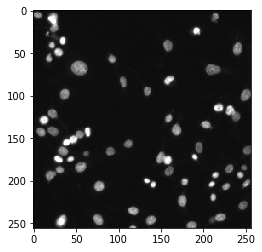

In [9]:
plt.imshow(images[list(images.keys())[0]])

In [10]:
def read_masks(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of masks, indexed by corresponding image name
    
    
    """

    masks = {}
    
    count = 0

    for root,dirs,files in os.walk(path):
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 500 == 0:
                    print("Masks Read: {}".format(count))
                count += 1

                # Read Masks
                submasks = []
                for mask_name in listdir(root + '/masks'):
                    mask_path = root + '/masks/{}'.format(mask_name)
                    if mask_path == '':
                        raise Exception("No Masks found in directory")  
                    submasks.append(imread(mask_path))
                masks[img_name] = submasks
    print("Completed processing {} masks".format(count))
    return masks

In [ ]:
masks = read_masks("../train_data")
pickle.dump(masks, open('../unprocessed_data/raw_train_masks.p', 'wb'))

Masks Read: 0
Masks Read: 500
Completed processing 670 masks


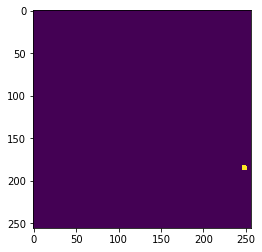

In [50]:
plt.imshow(masks[list(masks.keys())[0]][10])

## Test Images and Labels

In [9]:
def read_test_images(path):
    """ Read Images and Masks from Path

        Arguments:
            path
        
        Return:
            dictionary of image names, each containing dictionary of {image,masks}.
    
    
    """
    
    images = {}
    sizes = []
    img_names = []
    
    count = 0

    for root,dirs,files in os.walk(path):
        
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):
                
                if count % 500 == 0:
                    print("Read {} image".format(count))
                count += 1
                
                # Read Images
                img_path = root + '/images/%s' % img_name
                if img_path == '':
                    raise Exception("No Images found in directory")   
                img = imread(img_path)
                if img.shape[-1] != 3:
                    try:
                        img = img[:,:,:3]
                    except IndexError:
                        img = np.expand_dims(img,axis=-1)
                        img = np.repeat(img,3, axis=-1)
                images[img_name] = img
                sizes.append(img.shape)
                img_names.append(img_name)
    print("Completed processing {} images".format(count))

    return images, sizes, img_names


In [36]:
test_images, test_sizes, img_names = read_test_images("../test_data")
pickle.dump(test_images, open('raw_test_images.p', 'wb'))
pickle.dump(test_sizes, open('test_sizes.p', 'wb'))
pickle.dump(img_names, open('test_img_names.p', 'wb'))

Read 0 image
Completed processing 65 images


In [8]:
test_images, test_sizes, img_names = read_test_images("./test_data_2")

In [16]:
pickle.dump(test_images, open('../raw_test_images.p', 'wb'))
pickle.dump(test_sizes, open('../test_sizes.p', 'wb'))
pickle.dump(img_names, open('../test_img_names.p', 'wb'))

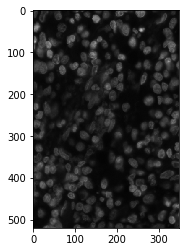

In [15]:
plt.imshow(test_images[list(test_images.keys())[0]])